In [ ]:
%cd /content/drive/MyDrive/odev_2

/content/drive/MyDrive/odev_2


In [ ]:
%ls

data/                     figures/                 models/       __pycache__/
dataset_operations.ipynb  hold_out_training.ipynb  odev_2.ipynb  scores/


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import adam_v2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Verinin Yüklenmesi

In [ ]:
X = np.load('data/X.npy')
y = np.load('data/Y.npy')
X_flatten = np.load('data/X_flatten.npy')

#Verinin Train, Test Uzaylarına Ayrılması

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)
X_train_flatten, X_test_flatten, _, _ = train_test_split(X_flatten, y, random_state=10, test_size=0.2)

#Modellerin tanımlanması

## Resnet

In [ ]:
def createModelResNet50V2():
    img_size = 256
    img_depth = 3
    model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                              input_shape=(
                                                  img_size, img_size, img_depth),
                                              weights='imagenet')
    for layer in model.layers:
        layer.trainable = True

    x = model.output

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    prediction = tf.keras.layers.Dense(
        4, activation='softmax', name='visualized_layer')(x)

    final_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=prediction)
    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
    final_model.compile(
        optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return final_model

## InceptionV3

In [1]:
def createModelInceptionV3():

    img_size = 256
    img_depth = 3
    model = tf.keras.applications.InceptionV3(include_top=False,
                                              input_shape=(
                                                  img_size, img_size, img_depth),
                                              weights='imagenet')
    for layer in model.layers:
        layer.trainable = True

    x = model.output

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    prediction = tf.keras.layers.Dense(
        4, activation='softmax', name='visualized_layer')(x)

    final_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=prediction)

    final_model.compile(
        optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return final_model


## Kendi CNN Mimarim

In [ ]:
def createModelMyCNN():

    img_size = 256
    img_depth = 3

    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(7, 7), padding='same',
                    activation='relu', input_shape=(img_size, img_size, img_depth)))
    model.add(Conv2D(filters=8, kernel_size=(7, 7),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(filters=16, kernel_size=(5, 5),
                    padding='same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(5, 5),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(
        3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(
        3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    optimizer = adam_v2.Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['accuracy'])

    return model

#Eğitim İşlemlerinin başlangıcı

## InceptionV3 Training

In [ ]:
model_inception = createModelInceptionV3()
model_path = 'models/hold_out/inceptionv3/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path + 'checkpoints',
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

history = model_inception.fit(X_train, y_train,
                    epochs=10,
                    callbacks=[model_checkpoint_callback],
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1)
model_inception.save(model_path + 'model.h5')

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(model_path +'history.csv')

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch,
              y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch,
              y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch,
              y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch,
              y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.savefig(model_path + "acc_loss_graph.png")
plt.clf()

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/10
41/41 [==============================] - 154s 3s/step - loss: 0.6036 - accuracy: 0.7775 - val_loss: 6.1799 - val_accuracy: 0.1822
Epoch 2/10
41/41 [==============================] - 111s 3s/step - loss: 0.2429 - accuracy: 0.9192 - val_loss: 1.5733 - val_accuracy: 0.5865
Epoch 3/10
41/41 [==============================] - 110s 3s/step - loss: 0.1707 - accuracy: 0.9471 - val_loss: 0.9604 - val_accuracy: 0.6953
Epoch 4/10
41/41 [==============================] - 128s 3s/step - loss: 0.1138 - accuracy: 0.9598 - val_loss: 0.4770 - val_accuracy: 0.8913
Epoch 5/10
41/41 [==============================] - 112s 3s/step - loss: 0.0955 - accuracy: 0.9682 - val_loss: 0.4552 - val_accuracy: 0.9188
Epoch 6/10
41/41 [==============================] - 111s 3s/step - loss: 0.1019 - accuracy: 0.9663 - val_loss: 0.2509 - val_accuracy: 0.9311
Epoch 7/10
41/41 [==============================] - 62s 2s/step - loss: 0.0893 - accuracy

<Figure size 1440x360 with 0 Axes>

#ROC Eğrisinin oluşturulması

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle

def create_roc_curve(y_test_encoded, y_pred_encoded, name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test_encoded[0])):
        fpr[i], tpr[i], _ = roc_curve(
            y_test_encoded[:, i], y_pred_encoded[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_encoded.ravel(), y_pred_encoded.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate(
        [fpr[i] for i in range(len(y_test_encoded[0]))]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(y_test_encoded[0])):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(y_test_encoded[0])
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], fpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(y_test_encoded[0])), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('figures/hold_out/roc_curve_'+name+'.png')
    plt.cla()
    plt.clf()

In [ ]:
y_pred = model_inception.predict(X_test)

create_roc_curve(y_test, y_pred, "inceptionv3")

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf_matr = confusion_matrix(y_test, y_pred)

FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
TP = np.diag(conf_matr)
TN = conf_matr.sum() - (FP + FN + TP)

acc = (TP + TN) / (TP + FP + FN + TN)
sen = TP / (TP + FN)
pre = TP / (TP + FP)
spe = TN / (TN + FP)
f1 = (2 * (pre * sen)) / (pre + sen)


sns.heatmap(conf_matr, annot=True)
plt.savefig("figures/hold_out/inceptionv3_conf_graph.png")
plt.clf()

scores = []
scores.append([np.mean(acc), np.mean(sen), np.mean(pre), np.mean(f1), np.mean(spe)])

df = pd.DataFrame(scores, columns=['acc', 'sen', 'pre', 'f1', 'spe'])
df.to_csv('scores/hold_out/inceptionv3_conf_graph_scores.csv')

<Figure size 432x288 with 0 Axes>

#Verinin ayrılması

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)
X_train_flatten, X_test_flatten, _, _ = train_test_split(X_flatten, y, random_state=10, test_size=0.2)

#Resnet50V2 Eğitimi

In [ ]:
model_resnet = createModelResNet50V2()
model_path = 'models/hold_out/resnet/'
history = model_resnet.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1)
model_resnet.save(model_path + 'model.h5')

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(model_path +'history.csv')

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch,
              y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch,
              y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch,
              y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch,
              y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.savefig(model_path + "acc_loss_graph.png")
plt.clf()

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/10
41/41 [==============================] - 94s 2s/step - loss: 1.2609 - accuracy: 0.4431 - val_loss: 14943436800.0000 - val_accuracy: 0.2083
Epoch 2/10
41/41 [==============================] - 64s 2s/step - loss: 1.0165 - accuracy: 0.5661 - val_loss: 53189.5859 - val_accuracy: 0.1822
Epoch 3/10
41/41 [==============================] - 64s 2s/step - loss: 0.9133 - accuracy: 0.6396 - val_loss: 474.0690 - val_accuracy: 0.2772
Epoch 4/10
41/41 [==============================] - 64s 2s/step - loss: 0.7869 - accuracy: 0.6967 - val_loss: 12.3535 - val_accuracy: 0.2864
Epoch 5/10
41/41 [==============================] - 64s 2s/step - loss: 0.6845 - accuracy: 0.7315 - val_loss: 1.8043 - val_accuracy: 0.4058
Epoch 6/10
41/41 [==============================] - 64s 2s/step - loss: 0.6491 - accuracy: 0.7549 - val_loss: 1.3595 - val_accuracy: 0.5697
Epoch 7/10
41/41 [==============================] - 64s 2s/step - loss: 0.5794

<Figure size 1440x360 with 0 Axes>

## Modelin sonuçlarının oluşturulması

In [ ]:
y_pred = model_resnet.predict(X_test)

create_roc_curve(y_test, y_pred, "resnet")

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf_matr = confusion_matrix(y_test, y_pred)

FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
TP = np.diag(conf_matr)
TN = conf_matr.sum() - (FP + FN + TP)

acc = (TP + TN) / (TP + FP + FN + TN)
sen = TP / (TP + FN)
pre = TP / (TP + FP)
spe = TN / (TN + FP)
f1 = (2 * (pre * sen)) / (pre + sen)


sns.heatmap(conf_matr, annot=True)
plt.savefig("figures/hold_out/resnet_conf_graph.png")
plt.clf()

scores = []
scores.append([np.mean(acc), np.mean(sen), np.mean(pre), np.mean(f1), np.mean(spe)])

df = pd.DataFrame(scores, columns=['acc', 'sen', 'pre', 'f1', 'spe'])
df.to_csv('scores/hold_out/resnet_conf_graph_scores.csv')

<Figure size 432x288 with 0 Axes>

# Verinin ayrılması

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)
X_train_flatten, X_test_flatten, _, _ = train_test_split(X_flatten, y, random_state=10, test_size=0.2)

 # Kendi CNN Mimarimin Eğitilmesi

In [ ]:
model_mycnn = createModelMyCNN()
model_path = 'models/hold_out/mycnn/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path + 'checkpoints',
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

history = model_mycnn.fit(X_train, y_train,
                    epochs=10,
                    callbacks=[model_checkpoint_callback],
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1)
model_mycnn.save(model_path + 'model.h5')

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(model_path +'history.csv')

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch,
              y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch,
              y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch,
              y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch,
              y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.savefig(model_path + "acc_loss_graph.png")
plt.clf()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
41/41 [==============================] - 25s 464ms/step - loss: 1.2595 - accuracy: 0.4351 - val_loss: 1.0798 - val_accuracy: 0.5406
Epoch 2/10
41/41 [==============================] - 15s 371ms/step - loss: 1.0095 - accuracy: 0.5722 - val_loss: 0.9243 - val_accuracy: 0.6447
Epoch 3/10
41/41 [==============================] - 15s 379ms/step - loss: 0.8198 - accuracy: 0.6561 - val_loss: 0.7959 - val_accuracy: 0.6723
Epoch 4/10
41/41 [==============================] - 17s 406ms/step - loss: 0.6846 - accuracy: 0.7212 - val_loss: 0.6898 - val_accuracy: 0.7580
Epoch 5/10
41/41 [==============================] - 13s 321ms/step - loss: 0.5798 - accuracy: 0.7694 - val_loss: 0.7518 - val_accuracy: 0.7044
Epoch 6/10
41/41 [==============================] - 17s 413ms/step - loss: 0.5214 - accuracy: 0.7982 - val_loss: 0.5696 - val_accuracy: 0.7871
Epoch 7/10
41/41 [==============================] - 13s 315ms/step - loss: 0.4244 - accuracy: 0.8418 - val_loss: 0.6363 - val_accuracy: 0.7688

<Figure size 1440x360 with 0 Axes>

## Modelin sonuçlarının oluşturulması

In [ ]:
y_pred = model_mycnn.predict(X_test)

create_roc_curve(y_test, y_pred, "mycnn")

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf_matr = confusion_matrix(y_test, y_pred)

FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
TP = np.diag(conf_matr)
TN = conf_matr.sum() - (FP + FN + TP)

acc = (TP + TN) / (TP + FP + FN + TN)
sen = TP / (TP + FN)
pre = TP / (TP + FP)
spe = TN / (TN + FP)
f1 = (2 * (pre * sen)) / (pre + sen)


sns.heatmap(conf_matr, annot=True)
plt.savefig("figures/hold_out/mycnn_conf_graph.png")
plt.clf()

scores = []
scores.append([np.mean(acc), np.mean(sen), np.mean(pre), np.mean(f1), np.mean(spe)])

df = pd.DataFrame(scores, columns=['acc', 'sen', 'pre', 'f1', 'spe'])
df.to_csv('scores/hold_out/mycnn_conf_graph_scores.csv')

<Figure size 432x288 with 0 Axes>

# Veri setinin ayrılması

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)
X_train_flatten, X_test_flatten, _, _ = train_test_split(X_flatten, y, random_state=10, test_size=0.2)

# KNN'in sisteme dahil edilmesi ve ilgili işlemler

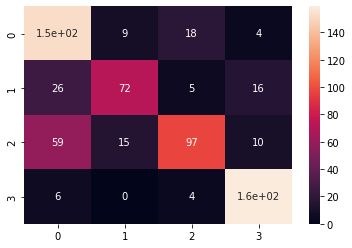

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train_flatten, y_train)

y_pred = model.predict(X_test_flatten)
create_roc_curve(y_test, y_pred, 'knn')

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

conf_matr = confusion_matrix(y_test, y_pred)

FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
TP = np.diag(conf_matr)
TN = conf_matr.sum() - (FP + FN + TP)

acc = (TP + TN) / (TP + FP + FN + TN)
sen = TP / (TP + FN)
pre = TP / (TP + FP)
spe = TN / (TN + FP)
f1 = (2 * (pre * sen)) / (pre + sen)

sns.heatmap(conf_matr, annot=True)
plt.savefig("figures/hold_out/knn_conf_graph.png")

scores = []
scores.append([np.mean(acc), np.mean(sen), np.mean(pre), np.mean(f1), np.mean(spe)])

df = pd.DataFrame(scores, columns=['acc', 'sen', 'pre', 'f1', 'spe'])
df.to_csv('scores/hold_out/knn_scores.csv')